In [16]:
import pandas as pd
import pm4py

df = pd.read_excel("loan.xlsx")
df

,eventName,idLoanRequest,tlEntryDate,tskDisplayName,tskDisplayNameEnglish
0,g,13862,2018-10-29 15:14:08.810,اطلاعات پرداخت,Payment Information
1,i,13862,2018-10-29 15:14:24.203,پرداخت گروهی وام,Group Loan Payment
2,g,13863,2018-08-26 11:48:45.220,اطلاعات پرداخت,Payment Information
3,i,13863,2018-08-26 11:50:21.840,پرداخت گروهی وام,Group Loan Payment
4,j,24603,2019-06-11 09:51:22.723,خواندن اطلاعات وام,Reading Loan Information
...,...,...,...,...,...
219,b,42854000,2017-05-28 13:44:25.187,اطلاع رسانی به متقاضی,Notifying the Applicant
220,d,42854000,2017-05-28 13:44:25.280,دستور پرداخت,Payment Order
221,f,42854000,2017-05-28 13:44:30.373,اطلاع به متقاضی,Informing the Applicant
222,e,42854000,2017-05-28 13:44:30.383,ثبت در سامانه حقوق,Recording in the Salary System


In [17]:
df = df.rename(columns={
    'idLoanRequest': 'case:concept:name',    # Case ID column
    'eventName': 'concept:name',             # Activity column
    'tlEntryDate': 'time:timestamp',         # Timestamp column
    # If 'tskDisplayName' is relevant, you might want to include it as an additional attribute
})


In [18]:
log = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')

## K-Means Clustering

c:\Users\HOSSEIN\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HOSSEIN\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HOSSEIN\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HOSSEIN\miniconda3\envs\gymenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

For n_clusters = 2, the average silhouette_score is : 0.6060186387103972
For n_clusters = 3, the average silhouette_score is : 0.6959702458864886
For n_clusters = 4, the average silhouette_score is : 0.9254418571188757
For n_clusters = 5, the average silhouette_score is : 0.9264714581484768
For n_clusters = 6, the average silhouette_score is : 0.9509612540668441
For n_clusters = 7, the average silhouette_score is : 0.9795918367346939
For n_clusters = 8, the average silhouette_score is : 0.9795918367346939
For n_clusters = 9, the average silhouette_score is : 0.9795918367346939
The best number of clusters is 7 with a silhouette score of 0.9795918367346939


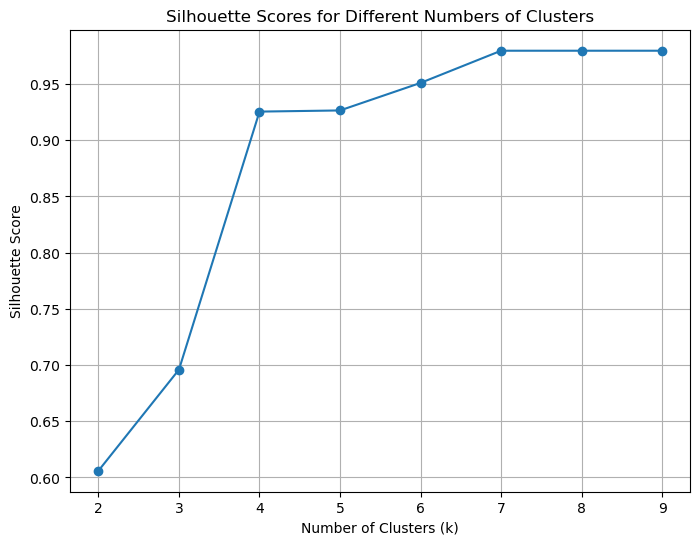

In [32]:
from sklearn.metrics import silhouette_score
from Levenshtein import distance as levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram


mapping = dict(zip(df['concept:name'], df['tskDisplayNameEnglish']))

# Replace 'concept:name' with 'tskDisplayName' in the sequences
df['mapped_concept:name'] = df['concept:name'].map(mapping)
case_groups = df.groupby('case:concept:name')['mapped_concept:name'].apply(list)
sequences = case_groups.tolist()

# Create a distance matrix using Levenshtein distance
num_sequences = len(sequences)
distance_matrix = np.zeros((num_sequences, num_sequences))

for i in range(num_sequences):
    for j in range(num_sequences):
        distance_matrix[i, j] = levenshtein_distance(sequences[i], sequences[j])

# Initialize variables to store the best number of clusters and corresponding silhouette score
best_k = None
best_silhouette_score = -1
silhouette_scores = []

# Define range for k
range_n_clusters = range(2, 10)  # Adjust range as needed

for k in range_n_clusters:
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(distance_matrix)
    
    # Compute silhouette score
    try:
        silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        silhouette_scores.append(silhouette_avg)
        
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

        # Update the best k and best silhouette score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_k = k
    except ValueError:
        print(f"Skipping k={k} due to ValueError in silhouette score computation.")
        continue

if best_k is not None:
    print(f"The best number of clusters is {best_k} with a silhouette score of {best_silhouette_score}")
else:
    print("Failed to compute a valid silhouette score for any k.")

# Ensure silhouette_scores and range_n_clusters have the same length
range_n_clusters = range(2, 2 + len(silhouette_scores))

# Plot the silhouette scores for each k
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


## K-Modes Clustering

For n_clusters = 2, the average silhouette_score is : 0.4862602183608483
For n_clusters = 3, the average silhouette_score is : 0.8403238106278232
For n_clusters = 4, the average silhouette_score is : 0.856081939125691
For n_clusters = 5, the average silhouette_score is : 0.7357056619098156
For n_clusters = 6, the average silhouette_score is : 0.8517806408641988
For n_clusters = 7, the average silhouette_score is : 0.9795918367346939
For n_clusters = 8, the average silhouette_score is : 0.9795918367346939
For n_clusters = 9, the average silhouette_score is : 0.9795918367346939
The best number of clusters is 7 with a silhouette score of 0.9795918367346939


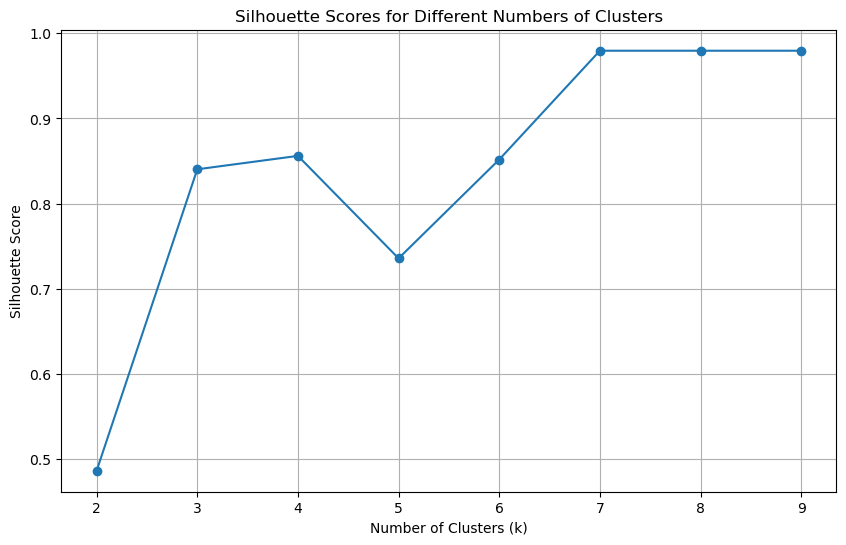

In [20]:
import pandas as pd
import numpy as np
from kmodes.kmodes import KModes
from Levenshtein import distance as levenshtein_distance
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



# Create a mapping from 'concept:name' to 'tskDisplayNameEnglish'
mapping = dict(zip(df['concept:name'], df['tskDisplayNameEnglish']))

# Replace 'concept:name' with 'tskDisplayNameEnglish' in the sequences
df['mapped_concept:name'] = df['concept:name'].map(mapping)
case_groups = df.groupby('case:concept:name')['mapped_concept:name'].apply(list)
sequences = case_groups.tolist()

# Pad sequences to the same length
max_len = max(len(seq) for seq in sequences)
padded_sequences = [seq + [''] * (max_len - len(seq)) for seq in sequences]

# Convert to DataFrame
sequences_df = pd.DataFrame(padded_sequences)

# Create a distance matrix using Levenshtein distance
num_sequences = len(sequences)
distance_matrix = np.zeros((num_sequences, num_sequences))

for i in range(num_sequences):
    for j in range(num_sequences):
        distance_matrix[i, j] = levenshtein_distance(''.join(sequences[i]), ''.join(sequences[j]))

# Initialize variables to store the best number of clusters and corresponding silhouette score
best_k = None
best_silhouette_score = -1
silhouette_scores = []

# Define range for k, ensuring k does not exceed the number of sequences
range_n_clusters = range(2, min(10, num_sequences + 1))  # Adjust range as needed

for k in range_n_clusters:
    # Apply KModes clustering
    kmodes = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42)
    cluster_labels = kmodes.fit_predict(sequences_df)
    
    # Compute silhouette score
    try:
        silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
        silhouette_scores.append(silhouette_avg)
        
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

        # Update the best k and best silhouette score
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_k = k
    except ValueError:
        print(f"Skipping k={k} due to ValueError in silhouette score computation.")
        continue

if best_k is not None:
    print(f"The best number of clusters is {best_k} with a silhouette score of {best_silhouette_score}")
else:
    print("Failed to compute a valid silhouette score for any k.")

# Ensure silhouette_scores and range_n_clusters have the same length
range_n_clusters = range(2, 2 + len(silhouette_scores))

# Plot the silhouette scores for each k
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# if best_k is not None:
#     # Apply KModes clustering with the best k
#     kmodes = KModes(n_clusters=best_k, init='Huang', n_init=5, random_state=42)
#     cluster_labels = kmodes.fit_predict(sequences_df)

#     # Interpret each cluster
#     for cluster_num in range(best_k):
#         cluster_sequences = [sequences[i] for i in range(len(sequences)) if cluster_labels[i] == cluster_num]
#         print(f"\nCluster {cluster_num} (size: {len(cluster_sequences)}):")
        
#         # Frequency analysis of activities
#         all_activities = [activity for sequence in cluster_sequences for activity in sequence]
#         activity_counts = Counter(all_activities)
#         print("Activity Frequencies:", activity_counts)
        
#         # Common sequences (showing first 5 sequences as an example)
#         print("Sample sequences:", cluster_sequences[:5])

#         # Visualize common activities
#         plt.figure(figsize=(10, 6))
#         activities, counts = zip(*activity_counts.items())
#         sns.barplot(x=list(activities), y=list(counts))
#         plt.title(f'Activity Frequencies in Cluster {cluster_num}')
#         plt.xticks(rotation=30)
#         plt.xlabel('Activity')
#         plt.ylabel('Frequency')
#         plt.show()


### Hirearchical Clustering and Best Method with Cophenetic Correlation Coefficient

In [33]:
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import squareform

condensed_dist_matrix = squareform(distance_matrix)

linkage_methods = ['single', 'complete', 'average', 'centroid', 'median', 'weighted', 'ward']
cophenetic_corr_coeffs = {}

for method in linkage_methods:
    Z = linkage(condensed_dist_matrix, method=method)
    c, coph_dists = cophenet(Z, condensed_dist_matrix)

    cophenetic_corr_coeffs[method] = c
    print(f"Cophenetic Correlation Coefficient for {method} linkage: {c:0.3f}")


Cophenetic Correlation Coefficient for single linkage: 0.847
Cophenetic Correlation Coefficient for complete linkage: 0.944
Cophenetic Correlation Coefficient for average linkage: 0.956
Cophenetic Correlation Coefficient for centroid linkage: 0.953
Cophenetic Correlation Coefficient for median linkage: 0.953
Cophenetic Correlation Coefficient for weighted linkage: 0.947
Cophenetic Correlation Coefficient for ward linkage: 0.833


In [42]:
pd.DataFrame(list(cophenetic_corr_coeffs.items())).to_clipboard()
# pd.DataFrame()

In [23]:
best_method = max(cophenetic_corr_coeffs, key=cophenetic_corr_coeffs.get)

print(f"The best linkage method is:  {best_method} \nwith a cophenetic correlation coefficient of:  {cophenetic_corr_coeffs[best_method]:0.3f}")

The best linkage method is:  average 
with a cophenetic correlation coefficient of:  0.962


In [24]:
from scipy.cluster.hierarchy import fcluster
Z_best = linkage(condensed_dist_matrix, method=best_method)

best_silhouette_score = -1
best_k = None
silhouette_scores = []

range_n_clusters = range(2, 10)

for k in range_n_clusters:
    cluster_labels = fcluster(Z_best, k, criterion='maxclust')

    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

    print(f"For k = {k} => avg. sil. is: {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_k = k

if best_k is not None:
    print(f"\nThe best K is: {best_k} \nwith a silhouette score of: {best_silhouette_score:0.3f}")
else:
    print("Failed to compute a valid silhouette score for any k.")


For k = 2 => avg. sil. is: 0.5692356592427218
For k = 3 => avg. sil. is: 0.7639434894910404
For k = 4 => avg. sil. is: 0.7339412392160104
For k = 5 => avg. sil. is: 0.9252172975349651
For k = 6 => avg. sil. is: 0.9550739636184309
For k = 7 => avg. sil. is: 0.9795918367346939
For k = 8 => avg. sil. is: 0.9795918367346939
For k = 9 => avg. sil. is: 0.9795918367346939

The best K is: 7 
with a silhouette score of: 0.980


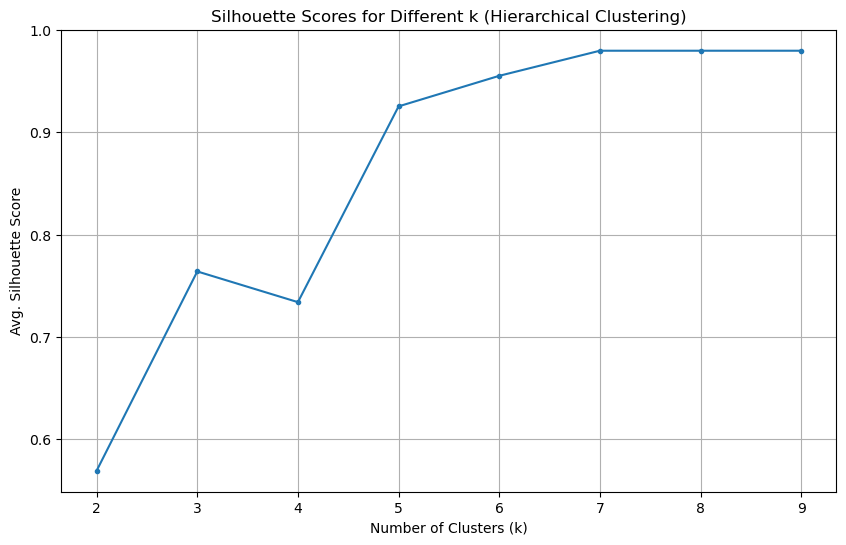

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='.')
plt.title('Silhouette Scores for Different k (Hierarchical Clustering)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Avg. Silhouette Score')
plt.grid(True)
plt.show()

In [27]:
case_df = pd.DataFrame(cluster_labels.tolist(), index=case_groups.index.tolist(), columns=['cluster_label'])
case_df.index.name = 'case:concept:name'
case_df.head()

,cluster_label
case:concept:name,
13862,5
13863,5
24603,2
28877,5
28879,5


In [44]:
case_df['cluster_label'].value_counts()

cluster_label
5    22
3    11
7     9
6     2
1     2
4     2
2     1
Name: count, dtype: int64

In [29]:
case_durations = log.groupby('case:concept:name').agg(case_start=('time:timestamp', min), case_end=('time:timestamp', max))
case_durations.index = case_durations.index.astype('int64')

case_durations['case_duration'] = case_durations.case_end - case_durations.case_start

case_df = case_df.merge(case_durations.case_duration, left_on='case:concept:name', right_index=True)

C:\Users\HOSSEIN\AppData\Local\Temp\ipykernel_14008\2683472683.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  case_durations = log.groupby('case:concept:name').agg(case_start=('time:timestamp', min), case_end=('time:timestamp', max))
C:\Users\HOSSEIN\AppData\Local\Temp\ipykernel_14008\2683472683.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  case_durations = log.groupby('case:concept:name').agg(case_start=('time:timestamp', min), case_end=('time:timestamp', max))


In [48]:
case_df.groupby('cluster_label')['case_duration'].mean()

cluster_label
1      3 days 23:39:35.063000
2      0 days 02:02:45.600000
3   0 days 00:00:33.984090909
4      0 days 00:02:26.960000
5   0 days 00:00:44.624136363
6    167 days 01:30:20.992000
7   1 days 14:54:55.931333333
Name: case_duration, dtype: timedelta64[ns]

In [49]:
task_counts = pd.DataFrame(log.groupby('case:concept:name').size(), columns=['task_counts'])
task_counts.index = task_counts.index.astype('int64')

case_df = case_df.merge(task_counts,how='inner', on='case:concept:name')

case_df.groupby('cluster_label')[['case_duration', 'task_counts']].mean()


,case_duration,task_counts
cluster_label,,
1,3 days 23:39:35.063000,12.0
2,0 days 02:02:45.600000,16.0
3,0 days 00:00:33.984090909,6.0
4,0 days 00:02:26.960000,2.0
5,0 days 00:00:44.624136363,2.0
6,167 days 01:30:20.992000,8.0
7,1 days 14:54:55.931333333,6.0


In [50]:
case_df.groupby('cluster_label')[['case_duration', 'task_counts']].mean().to_clipboard()

In [53]:
case_df[case_df.cluster_label == 2]

,cluster_label,case_duration,task_counts_x,task_counts_y,task_counts
case:concept:name,,,,,
24603,2,0 days 02:02:45.600000,16,16,16



Cluster 1 (size: 2):
Activity Frequencies: Counter({'Review and Feedback': 8, 'Reading Loan Information': 4, 'Creating Payment Request': 4, 'Payment': 4, 'Payment Notification': 4})
Average Times (seconds) for each activity: {'Reading Loan Information': 0.0285, 'Creating Payment Request': 521.4285, 'Review and Feedback': 20511.884, 'Payment': 299.83, 'Payment Notification': 260684.953}
Sample sequences: [['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification', 'Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification'], ['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification', 'Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification']]


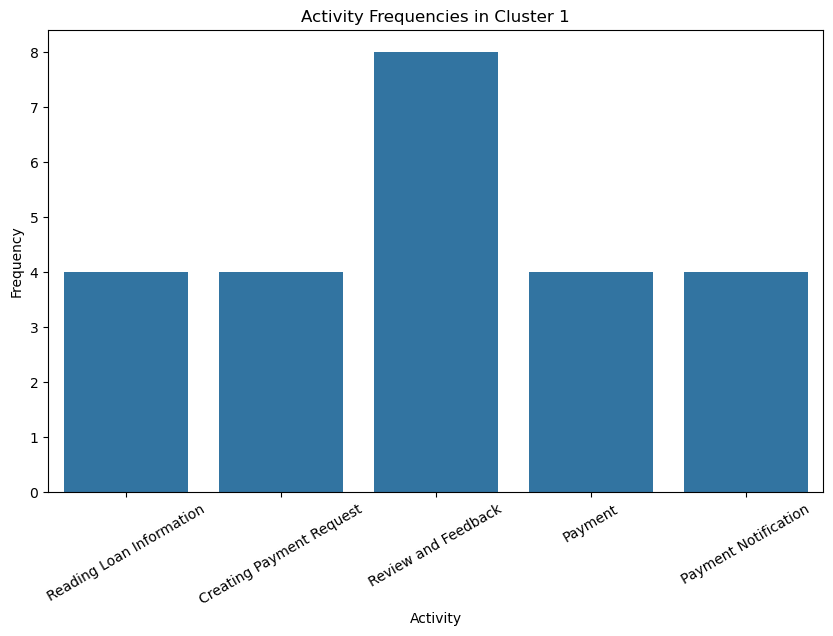

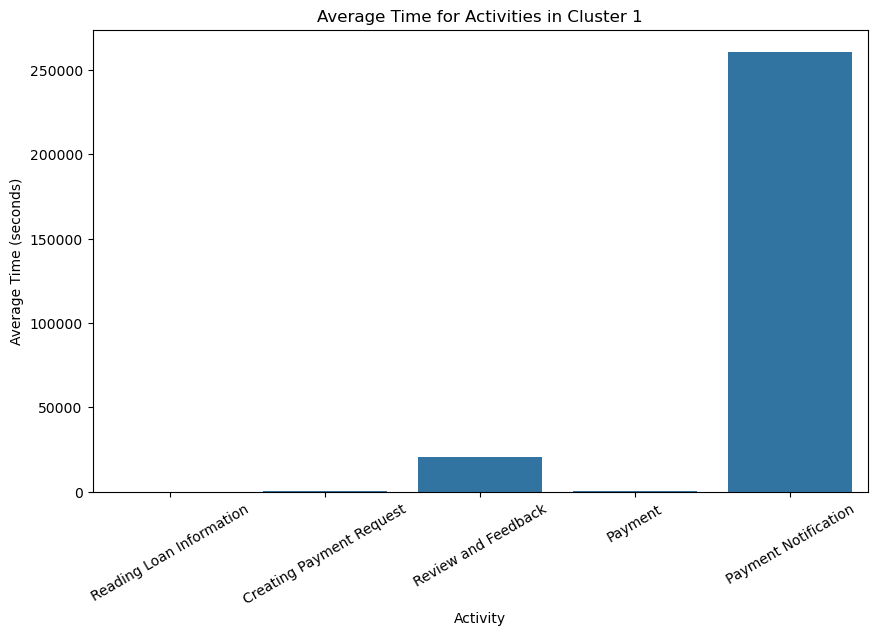


Cluster 2 (size: 1):
Activity Frequencies: Counter({'Review and Feedback': 5, 'Reading Loan Information': 3, 'Creating Payment Request': 3, 'Payment': 2, 'Payment Notification': 2, 'Notification of Rejected Request': 1})
Average Times (seconds) for each activity: {'Reading Loan Information': 0.07333333333333335, 'Creating Payment Request': 630.9403333333333, 'Review and Feedback': 18.0226, 'Notification of Rejected Request': 38.593, 'Payment': 1019.195, 'Payment Notification': 3305.463}
Sample sequences: [['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Notification of Rejected Request', 'Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification', 'Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification']]


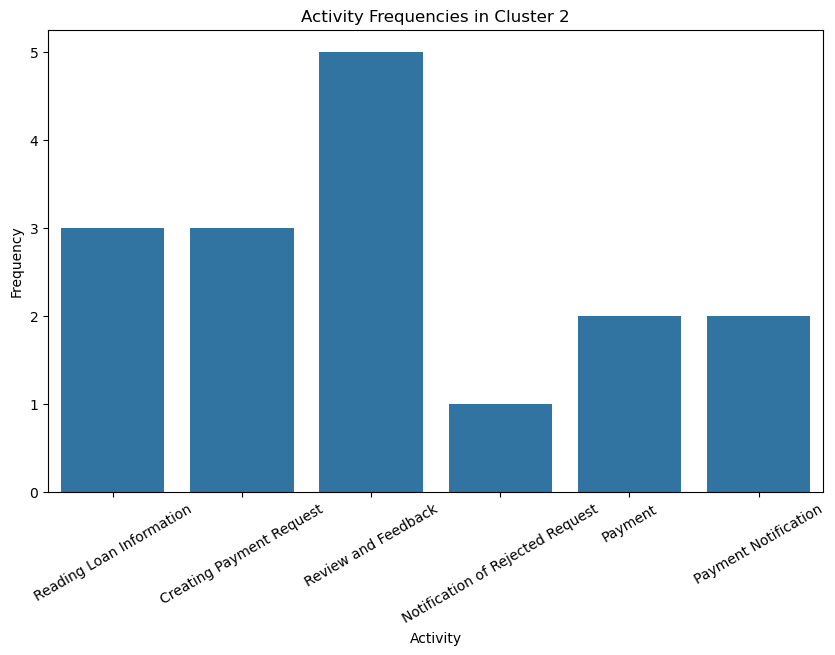

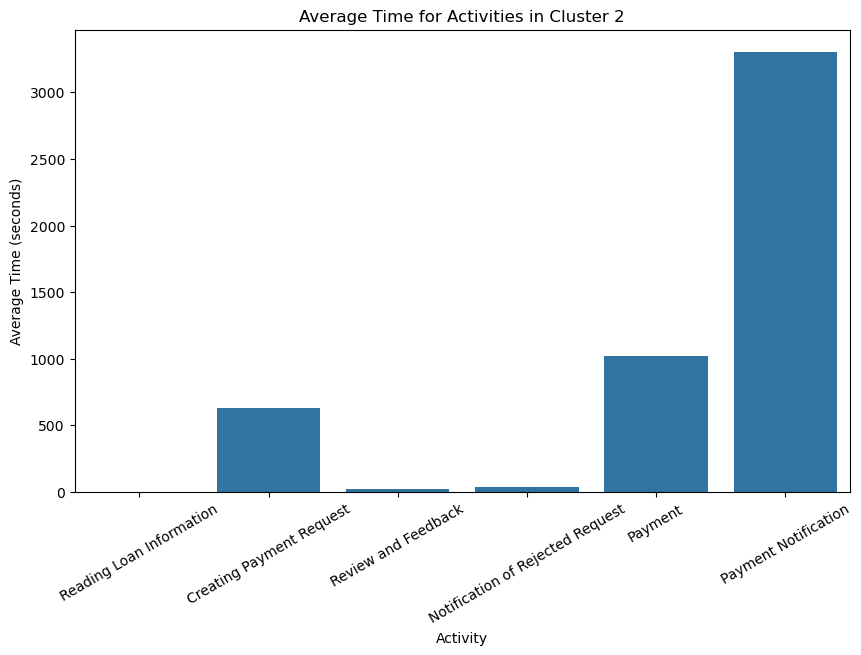


Cluster 3 (size: 11):
Activity Frequencies: Counter({'Selecting and Reviewing Loan for Payment': 11, 'Notifying the Applicant': 11, 'Payment Order': 11, 'Informing the Applicant': 11, 'Recording in the Salary System': 11, 'Confirmation of Loan Installments Registration in Salary System': 11})
Average Times (seconds) for each activity: {'Selecting and Reviewing Loan for Payment': 25.853000000000005, 'Notifying the Applicant': 0.1, 'Payment Order': 4.6370000000000005, 'Informing the Applicant': 0.009999999999999998, 'Recording in the Salary System': 9.44}
Sample sequences: [['Selecting and Reviewing Loan for Payment', 'Notifying the Applicant', 'Payment Order', 'Informing the Applicant', 'Recording in the Salary System', 'Confirmation of Loan Installments Registration in Salary System'], ['Selecting and Reviewing Loan for Payment', 'Notifying the Applicant', 'Payment Order', 'Informing the Applicant', 'Recording in the Salary System', 'Confirmation of Loan Installments Registration in S

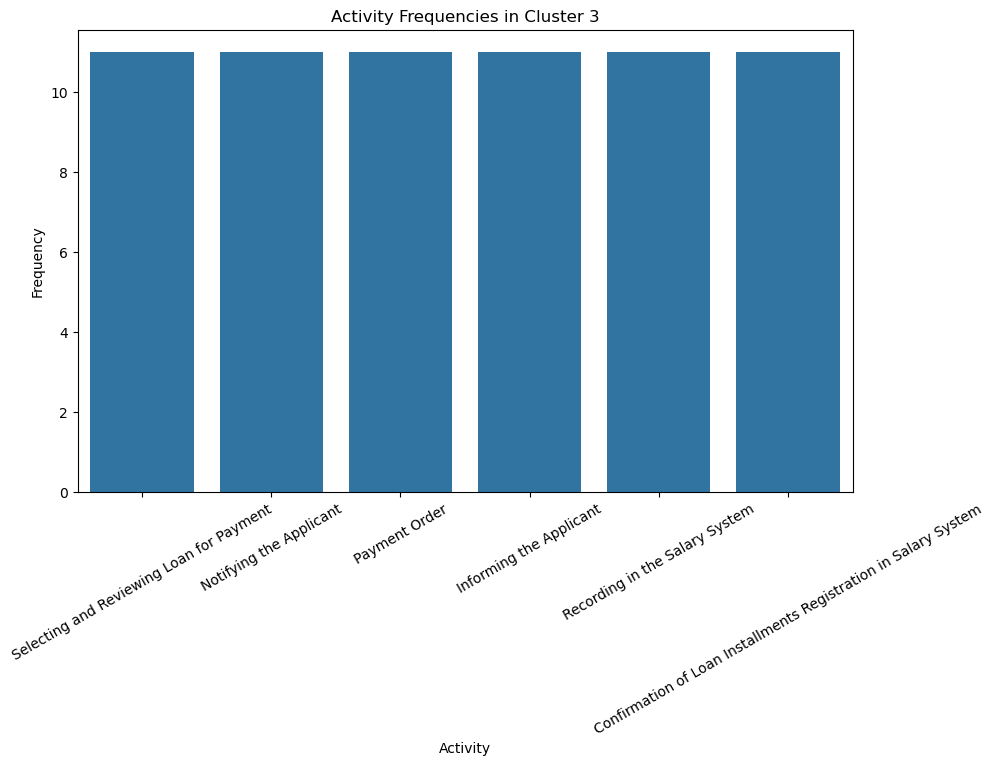

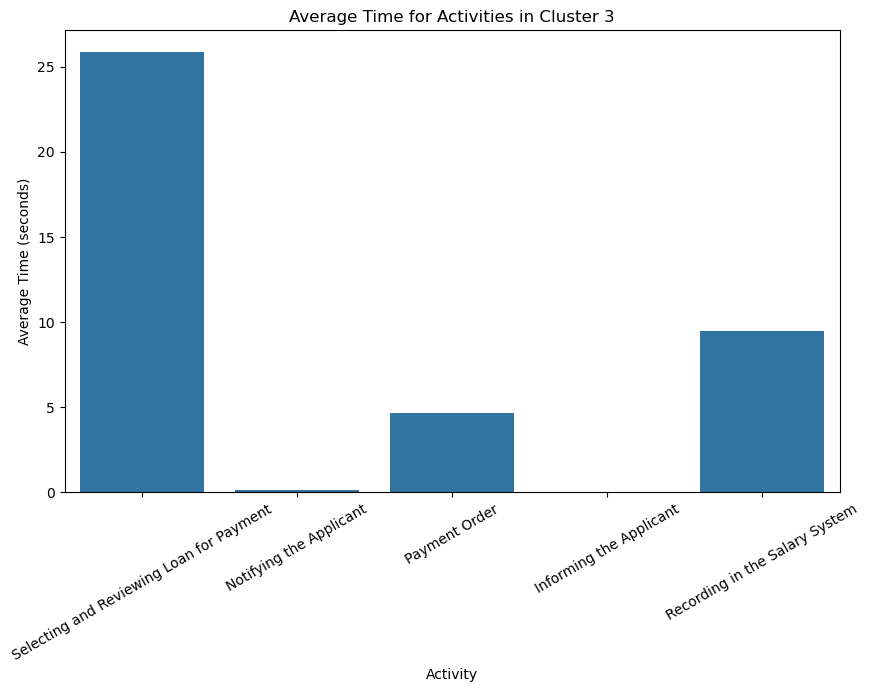


Cluster 4 (size: 2):
Activity Frequencies: Counter({'Selecting and Reviewing Loan for Payment': 2, 'A': 2})
Average Times (seconds) for each activity: {'Selecting and Reviewing Loan for Payment': 23.05}
Sample sequences: [['Selecting and Reviewing Loan for Payment', 'A'], ['Selecting and Reviewing Loan for Payment', 'A']]


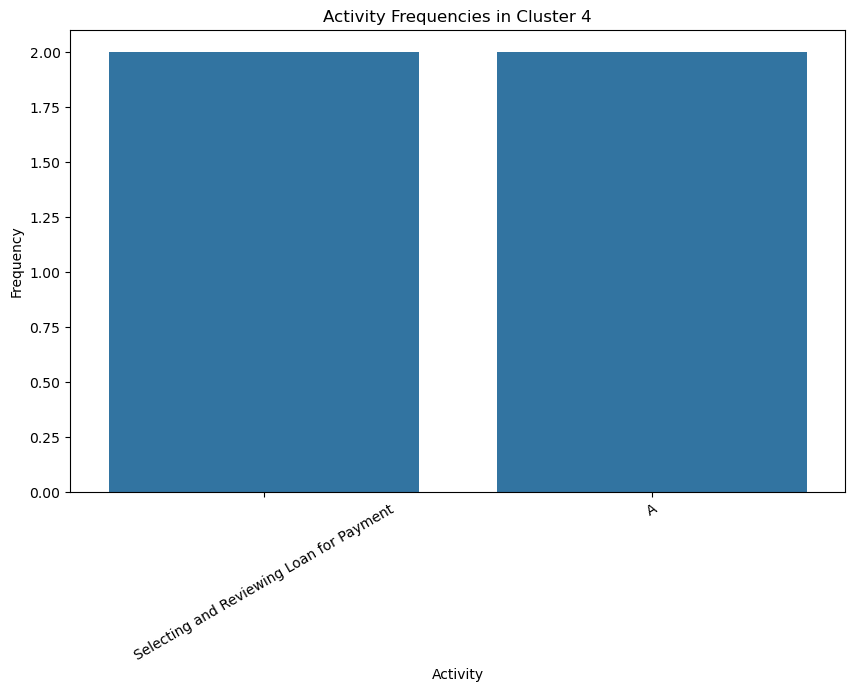

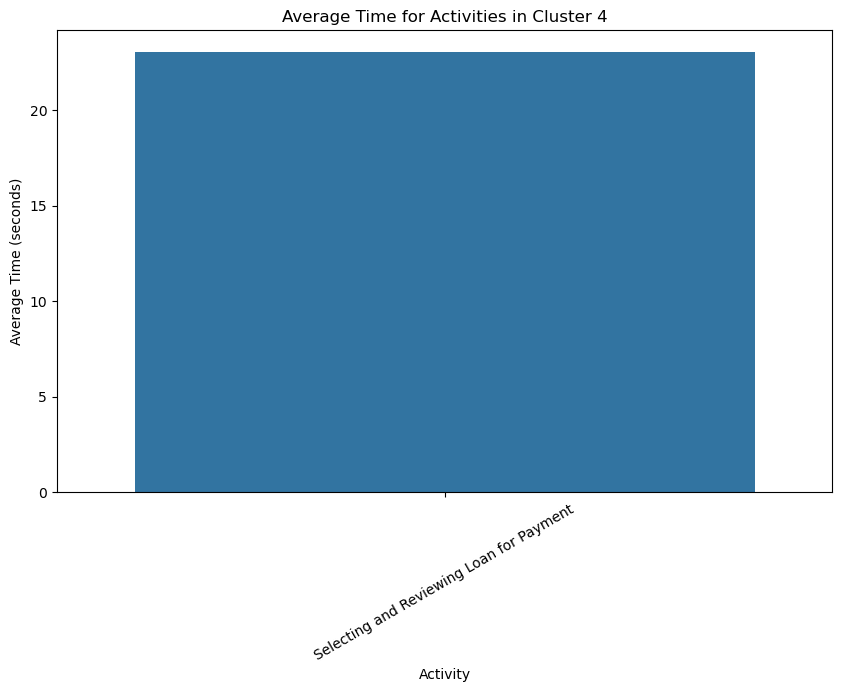


Cluster 5 (size: 22):
Activity Frequencies: Counter({'Payment Information': 22, 'Group Loan Payment': 22})
Average Times (seconds) for each activity: {'Payment Information': 15.393000000000008}
Sample sequences: [['Payment Information', 'Group Loan Payment'], ['Payment Information', 'Group Loan Payment'], ['Payment Information', 'Group Loan Payment'], ['Payment Information', 'Group Loan Payment'], ['Payment Information', 'Group Loan Payment']]


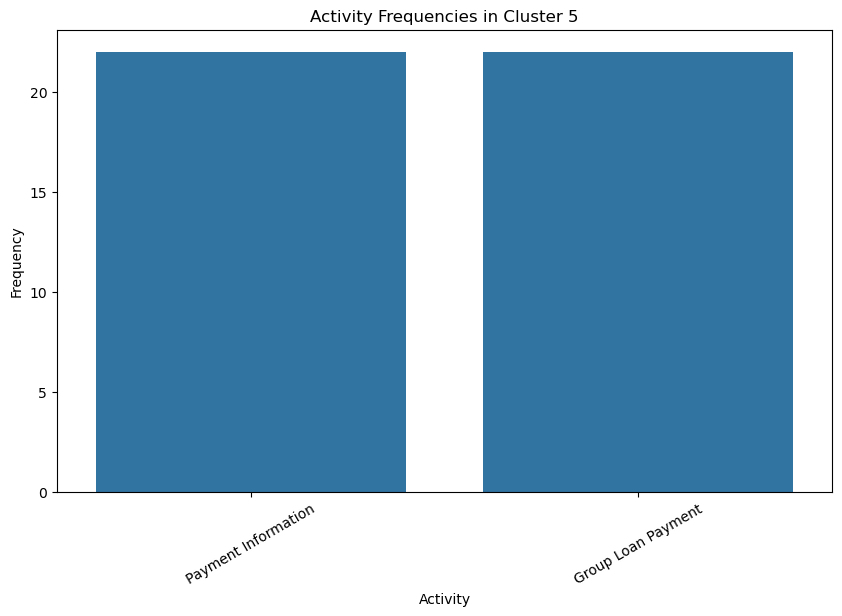

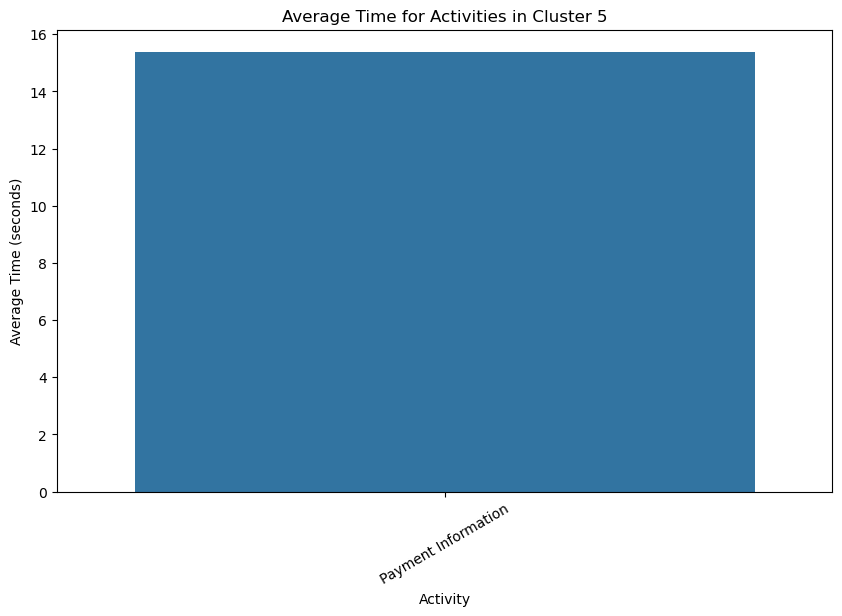


Cluster 6 (size: 2):
Activity Frequencies: Counter({'Review and Feedback': 4, 'Reading Loan Information': 2, 'Creating Payment Request': 2, 'Payment': 2, 'Payment Notification': 2, 'Payment Information': 2, 'Group Loan Payment': 2})
Average Times (seconds) for each activity: {'Reading Loan Information': 0.013, 'Creating Payment Request': 62.444, 'Review and Feedback': 58.36, 'Payment': 23.01, 'Payment Notification': 7005974.566, 'Payment Information': 14.687}
Sample sequences: [['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification', 'Payment Information', 'Group Loan Payment'], ['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification', 'Payment Information', 'Group Loan Payment']]


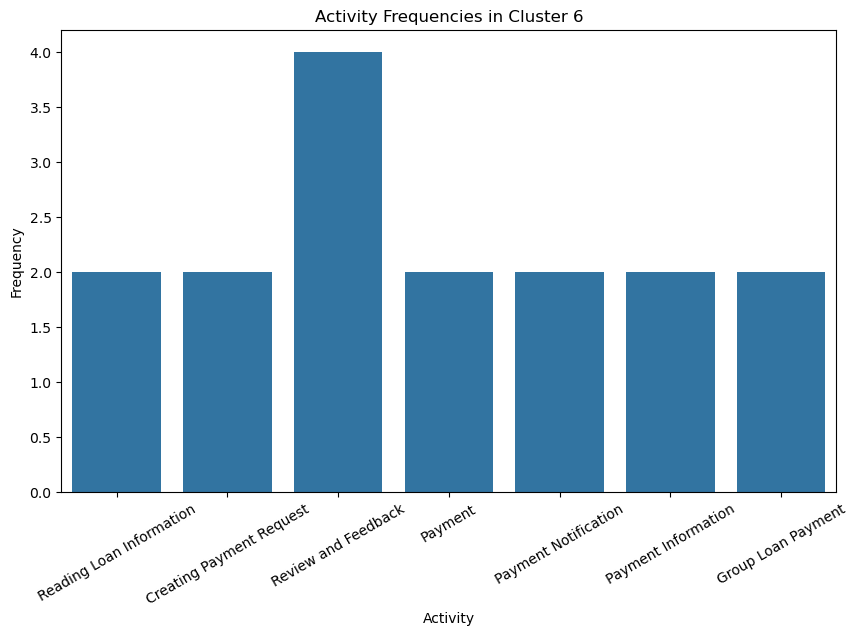

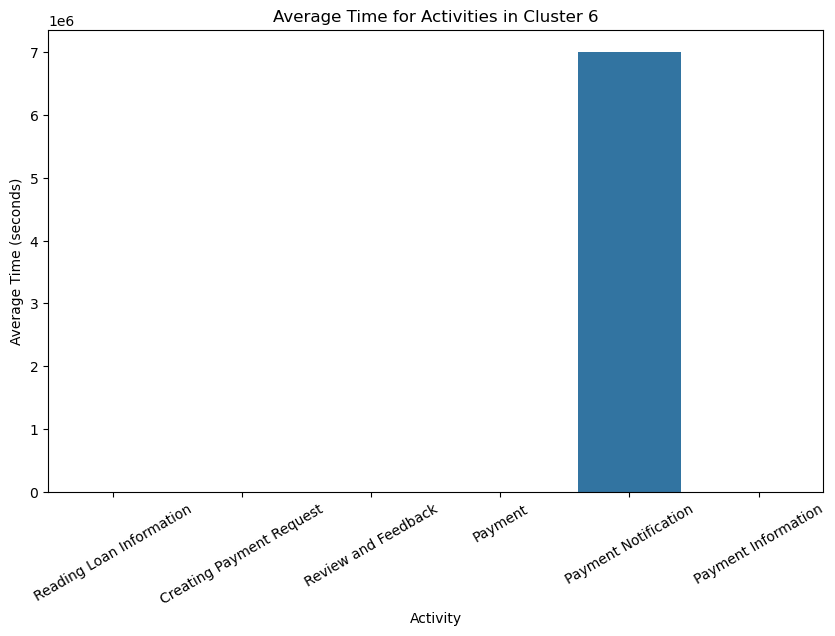


Cluster 7 (size: 9):
Activity Frequencies: Counter({'Review and Feedback': 18, 'Reading Loan Information': 9, 'Creating Payment Request': 9, 'Payment': 9, 'Payment Notification': 9})
Average Times (seconds) for each activity: {'Reading Loan Information': 0.016, 'Creating Payment Request': 482.477, 'Review and Feedback': 51673.133499999996, 'Payment': 58990.193}
Sample sequences: [['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification'], ['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification'], ['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification'], ['Reading Loan Information', 'Creating Payment Request', 'Review and Feedback', 'Review and Feedback', 'Payment', 'Payment Notification'], ['Reading Loan Information', 'Creating Payment Request', 'Re

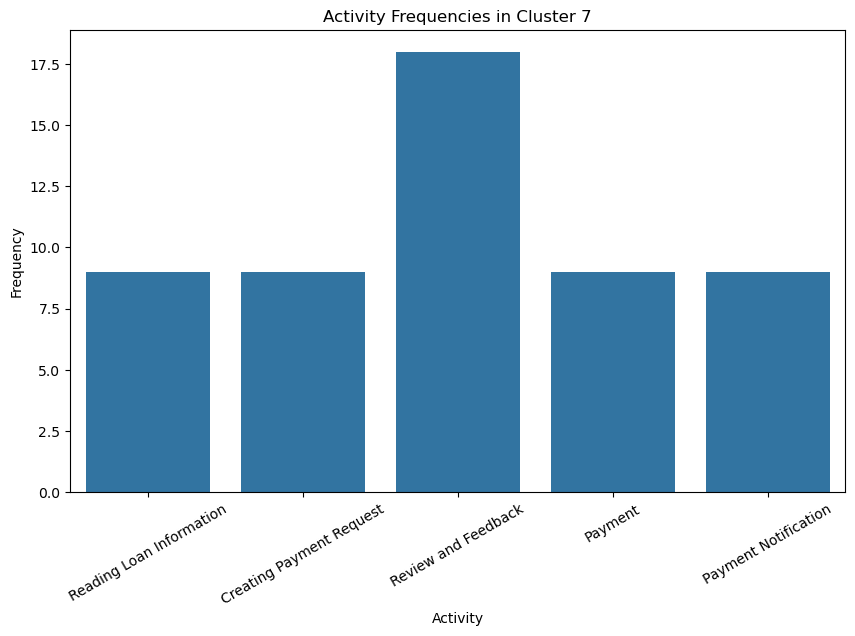

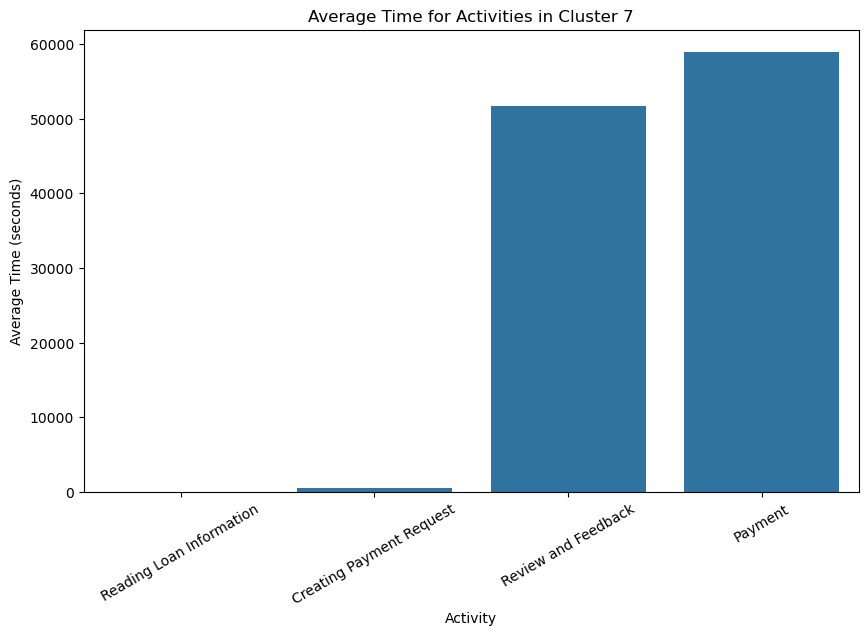

In [ ]:
if best_k is not None:
    # Apply hierarchical clustering with the best k
    cluster_labels = fcluster(Z_best, best_k, criterion='maxclust')

    # Function to calculate average times for each activity
    def calculate_avg_times(cluster_sequences, original_df):
        time_differences = {}
        for sequence in cluster_sequences:
            # Find corresponding original case:concept:name
            for case in original_df['case:concept:name'].unique():
                case_df = original_df[original_df['case:concept:name'] == case]
                if case_df['mapped_concept:name'].tolist() == sequence:
                    for i in range(len(case_df) - 1):
                        activity = case_df.iloc[i]['mapped_concept:name']
                        next_activity_time = case_df.iloc[i + 1]['time:timestamp']
                        current_activity_time = case_df.iloc[i]['time:timestamp']
                        time_diff = (next_activity_time - current_activity_time).total_seconds()
                        if activity not in time_differences:
                            time_differences[activity] = []
                        time_differences[activity].append(time_diff)
                    break
        avg_times = {activity: np.mean(times) for activity, times in time_differences.items()}
        return avg_times

    # Interpret each cluster
    for cluster_num in range(1, best_k + 1):
        cluster_sequences = [sequences[i] for i in range(len(sequences)) if cluster_labels[i] == cluster_num]
        print(f"\nCluster {cluster_num} (size: {len(cluster_sequences)}):")
        
        # Frequency analysis of activities
        all_activities = [activity for sequence in cluster_sequences for activity in sequence]
        activity_counts = Counter(all_activities)
        print("Activity Frequencies:", activity_counts)
        
        # Calculate average times for each activity
        avg_times = calculate_avg_times(cluster_sequences, df)
        print("Average Times (seconds) for each activity:", avg_times)
        
        # Common sequences (showing first 5 sequences as an example)
        print("Sample sequences:", cluster_sequences[:5])

        # Visualize common activities
        plt.figure(figsize=(10, 6))
        activities, counts = zip(*activity_counts.items())
        sns.barplot(x=list(activities), y=list(counts))
        plt.title(f'Activity Frequencies in Cluster {cluster_num}')
        plt.xlabel('Activity')
        plt.xticks(rotation=30)
        plt.ylabel('Frequency')
        plt.show()

        # Visualize average times for each activity
        if avg_times:
            plt.figure(figsize=(10, 6))
            activities, avg_time_values = zip(*avg_times.items())
            sns.barplot(x=list(activities), y=list(avg_time_values))
            plt.title(f'Average Time for Activities in Cluster {cluster_num}')
            plt.xticks(rotation=30)
            plt.xlabel('Activity')
            plt.ylabel('Average Time (seconds)')
            plt.show()